In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
#import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import random
import math
import json
import ast
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# ===========================================================
# ================= Data Collecting Class ===================
# ===========================================================
class data_collect():
    def __init__(self, normalize_function = 2, normalize_company = 0, num_range = 1, train_size = 70, 
                 val_size = 15, test_size = 15, start_point_diff = 25, start_point_deviation = 5, 
                 length = 25, pred_length = 5, company_group = True, random_batch = False, 
                 no_change_range = 5, data_points = range(0,14), label_type = 0):
        self.normalize_function = normalize_function
        self.normalize_company = normalize_company
        self.num_range = num_range
        self.train_size = train_size
        self.val_size = val_size
        self.test_size = test_size
        self.start_point_diff = start_point_diff
        self.start_point_deviation = start_point_deviation  
        self.length = length
        self.pred_length = pred_length
        self.no_change_range = no_change_range
        self.company_group = company_group
        self.random_batch = random_batch
        self.data_points = data_points
        self.label_type = label_type


    def format_data(self, data, filename):
        # Generate fake data for testing if no data is given
        if (data == None):  
            # For fake data, assume dimension size
            num_data_per_day = 14
            num_companies = 161
            num_days = 820
            data = random_input_gen(num_data_per_day, num_companies, num_days)
        elif (data == True):
            # Read data from .json file
            data = read_from_database_to_list(self.data_points, filename)
            # Get length of data input
            num_data_per_day = len(data[0][0])
            num_companies = len(data[0])
            num_days = len(data)
        
        
        # Add Labels
        data = add_labels(data, self.normalize_function, self.normalize_company, self.num_range, self.pred_length, self.no_change_range, self.data_points, self.label_type)

        # Return batched the data (3 tensors)
        return batch(data, self.train_size, self.val_size, self.test_size, self.start_point_diff, self.start_point_deviation, self.length, self.pred_length, self.company_group, self.random_batch)

    def get_label_frequency(self, data, dataset_type):
        data_loader = torch.utils.data.DataLoader(data, batch_size=1)
        zeros = 0
        ones = 0
        half = 0
        for data_item, data_label in data_loader:
            label_to_count = data_label.tolist()
            if (self.label_type == 0):
                if (self.company_group):
                    for i in label_to_count:
                        for j in i:
                            if (j == 0.0):
                                zeros += 1
                            elif (j == 0.5):
                                half += 1
                            elif (j == 1.0):
                                ones += 1
                else:
                    for i in label_to_count:
                        if (i == 0.0):
                            zeros += 1
                        elif (i == 0.5):
                            half += 1
                        elif (i == 1.0):
                            ones += 1
            elif (self.label_type == 1):
                if (self.company_group):
                    for i in label_to_count:
                        for j in i:
                            if (j == 0):
                                zeros += 1
                            elif (j == 1):
                                half += 1
                            elif (j == 2):
                                ones += 1
                else:
                    for i in label_to_count:
                        if (i == 0):
                            zeros += 1
                        elif (i == 1):
                            half += 1
                        elif (i == 2):
                            ones += 1
        print("0.0: " + str(zeros))
        print("0.5: " + str(half))
        print("1.0: " + str(ones))
        print(dataset_type.upper() + " SET LABEL FREQUENCY")
        print("Percent of 0.0 label: ", zeros / (zeros + ones + half))
        print("Percent of 0.5 label: ", half / (zeros + ones + half))
        print("Percent of 1.0 label: ", ones / (zeros + ones + half))
        return None

In [0]:
# ===========================================================
# ================= Random input generator ==================
# ===========================================================

# 9 input per day       --> dim 1
# 165 companies         --> dim 2
# ~763 days             --> dim 3

def random_input_gen(num_data_per_day = 11, num_companies = 161, num_days = 820, data_points = range(0,14)): # random numbers ranging from +- 100,000,000,000 (100 billion)
    data = [[[None for k in range(num_data_per_day)] for j in range(num_companies)] for i in range(num_days)]
    for i in range(num_days):
        for j in range(num_companies):
            for k in range(num_data_per_day):
                data[i][j][k] = random.randint(-100000000000,100000000001)
    # Force numbers to ensure logarithmic normalization works
    data[0][0][0] = 15
    data[0][0][1] = 0.05
    return data

# ============================================================
# ===== Formatting data from .json to dictionary to list =====
# ============================================================

# data_points = list    --> Contains all indexes that are desired
#                                   ~~~ RATIOS ~~~
#                       --> 0 = EPS, 1 = PE ratio, 2 = PPS,
#                       --> 3 = asset turnover 4 = cash flow,
#                       --> 5 = current ratio, 6 = return on equity,
#                       --> 7 = working capital
#                                 ~~~ Stock Data ~~~
#                       --> 8 = Closing stock price,
#                       --> 9 = 14-day moving avg,
#                       --> 10 = 37-day moving average

def read_from_database_to_list(data_points = range(0,14), filename = "data_list_complete.json"):      # Take in raw str, and convert to dictionary, then to list

        with open(filename, "r") as f:              # *******FILE LOCATION/NAME MAY DIFFER ACCORDING TO YOUR REQUIREMENTS******
                content = f.readlines()
        content = [x.strip() for x in content] 
        data = []
        for i in range(0,len(content)):
                data.append(ast.literal_eval(content[i]))       # Converting to dictionary

        data = data[0]
        list_companies = list(data["2019-07-17"].keys())        # All company symbols (anyday works after april 14th 2019)
        list_companies.sort(reverse = False)                    # Sort alphabetically company names

        list_days = list(data.keys())                           # All database days
        list_days = sorted(list_days, key = sorting)            # Sort days in past -> future order
                
        bad_companies = ["WLKP", "VMC", "VRS", "REX", "USLM"]   # These companies data are incomplete. To be removed (not enough data) --> I ADDED "USLM" TO MAKE IT WORK ???
        bad_days = []                                           # List of incomplete days (mostly comprised of days before april 14th 2019)

        for day in list_days:                                   # Delete bad days and companies
                num_companies = len(data[day])
                for company in list_companies:
                        if (company in bad_companies and company in data[day]):
                                del data[day][company]
                        if (num_companies < 160):
                                del data[day]
                                bad_days.append(day)
                                break

        for company in bad_companies:                           # Remove bad companies from company list
                if(company in list_companies):
                        list_companies.remove(company)

        for day in bad_days:                                    # Remove bad days from days list
                list_days.remove(day)
        
        # Give AGX data for April 14th (accidentally omitted)
        # data["2016-04-14"]["AGX"] = data["2016-04-15"]["AGX"]


        num_days = len(data)                                    # Dimensions of data
        num_companies = len(data["2016-04-15"])
        num_data_points = len(data_points)


        list_data = [[[0 for i in range(num_data_points)] for j in range(num_companies)] for k in range(num_days)]

        # Input all data to premade 3D list in order    
        counter_i = 0
        counter_j = 0
        counter_k = 0

        for day in list_days:
                for company in list_companies:
                        for data_point in data_points:
                                list_data[counter_i][counter_j][counter_k] = data[day][company][data_point]
                                counter_k += 1
                        counter_k = 0
                        counter_j += 1
                counter_j = 0
                counter_i += 1
        return list_data            # Type list with all requested data

def sorting(L):                     # Function to sort the days in chronological order
        splitup = L.split('-')
        return splitup[0], splitup[1], splitup[2]

# ===========================================================
# ====================== Normalization ======================
# ===========================================================

# normalize_function = 0    --> No normalization                (Baseline model did not train)
# normalize_function = 1    --> linear normalization            (Baseline model did not train)
# normalize_function = 2    --> logarithmic normalization       (Only function that works for baseline model)

# normalize_company = 0     --> normalize inside each company   (Only normalization that works for baseline model)
# normalize_company = 1     --> normalize across all companies  (Did not work for baseline model)

# range = 0                 --> no limit
# range = 1                 --> [-1, 1]
# range = 2                 --> [ 0, 1]

def normalize_data(data, normalize_function = 0, normalize_company = 0, num_range = 0):
    
    # Simple error checking
    if ((num_range != 0 and num_range != 1 and num_range != 2) or (normalize_company != 0 and normalize_company != 1) or (normalize_function != 0 and normalize_function != 1 and normalize_function != 2)):
        print("invalid input")
        return False

    if ((range == 1 or range == 2) and normalize_function == 0):
        print("cannot limit range with no normalization")
        return False
    
    if (range == 0 and normalize_function != 0):
        print("must limit range when normalizing data")
        return False
    
    num_days = len(data)                # Get data dimensions
    num_companies = len(data[0])
    num_data_per_day = len(data[0][0])

    if (normalize_function == 2):       # Take the log 10 of all numbers if we perform logarithmic normalization, else proceed to obtain max/min values
        for i in range(num_days):
            for j in range(num_companies):
                for k in range(num_data_per_day):
                    data[i][j][k] = log_normalization(data[i][j][k])
    
    # 2D list to record each max/min values for each input variable type (the 8 ratios and 3 stock price data)
    maxmin_values = [[0.0,0.0] for i in range(num_data_per_day)]
    div_by_zero_count = 0
    if (normalize_company == 0):
        for i in range(num_companies):
            for j in range(num_days):
                for k in range(num_data_per_day):
                    if (maxmin_values[k][1] < data[j][i][k]):
                        maxmin_values[k][1] = data[j][i][k]
                    if (maxmin_values[k][0] > data[j][i][k]):
                        maxmin_values[k][0] = data[j][i][k]
                    
            # Normalize within a single company
            for j in range(num_days):
                for k in range(num_data_per_day):
                    try:
                        data[j][i][k] = (data[j][i][k] - maxmin_values[k][0]) / (maxmin_values[k][1] - maxmin_values[k][0])
                    except:
                        div_by_zero_count += 1
                        '''
                        print("Error: DIVISION BY ZERO")
                        print("day number:     ", j)
                        print("company number: ", i)
                        print("data index:     ", k)
                        '''

    elif (normalize_company == 1):
        for i in range(num_companies):
            for j in range(num_days):
                for k in range(num_data_per_day):
                    if (maxmin_values[k][1] < data[j][i][k]):
                        maxmin_values[k][1] = data[j][i][k]
                    if (maxmin_values[k][0] > data[j][i][k]):
                        maxmin_values[k][0] = data[j][i][k]
                    
        # Normalize for all data across all companies
        for i in range(num_companies):
            for j in range(num_days):
                for k in range(num_data_per_day):
                    try:
                        data[j][i][k] = (data[j][i][k] - maxmin_values[k][0]) / (maxmin_values[k][1] - maxmin_values[k][0])
                    except:
                        div_by_zero_count += 1
                        '''
                        print("Error: DIVISION BY ZERO")
                        print("day number:     ", j)
                        print("company number: ", i)
                        print("data index:     ", k)
                        '''
    print("Num zero data points: " + str(div_by_zero_count))
    # Normalize the range of the data
    if (num_range == 1):
        for i in range(num_days):
            for j in range(num_companies):
                for k in range(num_data_per_day):
                    data[i][j][k] = (data[i][j][k] - 0.5) * 2.0

    # Return normalize data of type list
    return data

def log_normalization(x):   # Log 10 normalization function
    if (x < 0):
        return -1 * math.log10((-1 * x) + 1)
    else:
        return math.log10(x + 1)

# ===========================================================================
# ========================= Labeling and Formatting =========================
# ===========================================================================

# Label = 1  increase in price
# Label = 0  no change in price (within percent error margin no_change_range)
# Label = -1 decrease in price

def add_labels(data, normalize_function = 2, normalize_company = 0, num_range = 1, pred_length = 5, no_change_range = 5, data_points = range(0,11), label_type = 0):
    # Get dimensions of data
    num_days = len(data)
    num_companies = len(data[0])

    # Get closing price's index
    if (8 not in data_points):
        print("Data does not contain closing stock price")
    price_index = data_points.index(8)
    
    # Label each input with the price 5 working days later
    labeled_data = []
    labeled_data_by_day =[]
    for i in range(num_days):
        for j in range(num_companies):
            if (num_days - i > pred_length):     # We can give a label
                if (data[i][j][price_index] > data[i + pred_length][j][price_index]*(1+(no_change_range/100.0))):     # Increase in price
                    label = 1.0
                elif (data[i][j][price_index] < data[i + pred_length][j][price_index]*(1-(no_change_range/100.0))):   # Decrease in price
                    label = 0.0
                else:                           # No change in price (range of allowance)
                    label = 0.5
            else:                               # We cannot give a label (no price 5 days ahead available yet)
                label = None
            if (label != None and label_type == 1):
                label = int(label*2.0)
            labeled_data_by_day.append(label)
        labeled_data.append(labeled_data_by_day)
        labeled_data_by_day = []
    
    # Normalize the data
    normalized_data = normalize_data(data, normalize_function, normalize_company, num_range)

    # Add labels to the normalized data
    formatted_data = []
    for day in range(len(normalized_data)):
        formatted_day_data = []
        for company in range(len(normalized_data[day])):
            formatted_day_data.append([normalized_data[day][company], labeled_data[day][company]])
        formatted_data.append(formatted_day_data)

    # Return type list with labels attached
    return formatted_data

# ============================================================
# ========================= Batching =========================
# ============================================================

# random = False    --> means first 70% months are training, next 15% are validation
#                       and next 15% are test (assuming percentages did not change)
# random = True     --> randomly pick 70% of months, 15% of months, and 15% of months for 
#                       train/val/test data

# start_point_diff  --> how far apart are the first days in adjacent batchs

# train_size, val_size, test_size   --> percentage of batches to be in each set (must add to 100%)

# start_point_deviation --> the start_point can deviate +- 5 (for example) from the original start_point_diff it was set for

# length        --> how many days in one "item". Days being the days where the market is open for trade

# company_group = True  --> all 165 companies at once
# company_group = False --> 1 company at a time

def batch(data, train_size = 70, val_size = 15, test_size = 15, start_point_diff = 25, start_point_deviation = 5, length = 25, pred_length = 5, company_group = True, random_batch = False):
    # Ensure percentages add up properly
    if (train_size + val_size + test_size != 100):
        print("ensure train_size + val_size + test_size = 100%")
        return None, None, None

    num_days = len(data)
    num_companies = len(data[0])

    # Use start_point_diff, start_point_deviation, and length to get the day stamps we will cover
    times = []
    time_start = 0
    while((time_start + length + pred_length) < num_days):  # Note that the case where we deal with individual companies, we still give the same start date for each batch item
        times.append(time_start)
        time_start = time_start + start_point_diff
    
    for time in range(0,len(times)):
        if (times[time] != 0):
            times[time] += random.randint(-pred_length,pred_length)
   
    # Batching the data
    # Batch data according to start_point_diff, start_point_deviation, length, and company_group
    batched_data = []
    if (company_group):                                    # All 200 companies at once (for finding relationship between companies)
        for i in times:                                    # Iterate through start days
            single_batch = []
            price_label = []
            for day in range(i, i + length):               # Iterate through the length of data per item
                count = 0
                single_day = []
                for companies in range(num_companies):
                    for ratios in data[day][companies]:    # Iterate through all companies
                        if (type(ratios) is list):
                            single_day.append(ratios)
                            count += 1
                        elif ((type(ratios) is int or type(ratios) is float) and day == i + length - 1):
                            price_label.append(ratios)
                single_batch.append(single_day)
            batched_data.append([single_batch,price_label])
    else:                                                   # sOne company at a time (no relationship between companies)
        for i in times:                                         # Iterate through start days
            for companies in range(num_companies):               # Iterate through the length of data per item
                price_label = 0
                single_company = []
                for day in range(i, i + length):
                    for ratios in data[day][companies]:    # Iterate through all companies
                        if (type(ratios) is list):
                            single_company.append(ratios)
                        elif ((type(ratios) is int or type(ratios) is float) and day == i + length - 1):
                            price_label = ratios
                batched_data.append([single_company,price_label])
                
    if (random_batch):
        random.shuffle(batched_data)
        
    train_val_split = int(len(batched_data)*train_size/100.0)
    val_test_split = int(len(batched_data)*(train_size + val_size)/100.0)

    train = batched_data[:train_val_split]
    val = batched_data[train_val_split:val_test_split]
    test = batched_data[val_test_split:]

    train_data = data_to_tensor(train, company_group)
    val_data = data_to_tensor(val, company_group)
    test_data = data_to_tensor(test, company_group)
    
    # Return 3 tensors
    return train_data, val_data, test_data

def data_to_tensor(batched_data, company_group):
    tensor_data = []
    if (company_group):
      for i in batched_data:
        item_tuple = (torch.FloatTensor(i[0]),torch.as_tensor(i[1]))
        tensor_data.append(item_tuple)
    else:
      for i in batched_data:
        item_tuple = (torch.FloatTensor(i[0]),torch.as_tensor(i[1]))
        tensor_data.append(item_tuple)
    # Return data tensor and label tensor together in a tuple
    return tensor_data

In [0]:
# ===================================================================
# ==================== EXPLANATION OF PARAMETERS ====================
# ===================================================================

# ------ Data Dimensions ------
# 9 input per day       --> dim 1 (if we only want to do stock prices, we can extract it ourselves)
# 165 companies         --> dim 2
# ~763 days             --> dim 3
 
# ------ Data input ------
# data = None       (randomly generate between -100 billion and 100 billion)
# data = Some_list  (normal input)

# ------ Normalization ------
# normalize_function = 0    (no normalization)
# normalize_function = 1    (linear normalization) --> Horibly failed for random case, prob for real case too
# normalize_function = 2    (logarithmic normalization)

# normalize_company = 0     (normalize within each company)
# normalize_company = 1     (normalize across all companies)

# num_range = 0             (no normalization range)
# num_range = 1             (normalization range [-1,1])
# num_range = 2             (normalization range [0,1])

# ------ Batching ------
# start_point_diff = m          (m working days between two adjacent batch items) --> Influences size of train/val/test dataset
#                               ex. start_point_diff = 25                                   -->     start_days = [0,25,50,75,100,...]
# start_point_deviation = n     (+- n days for deviation from the evenly split start points. Cannot go below 0.)
#                               ex. start_point_diff = 25, start_point_deviation = 5        -->     start_days = [2,24,55,70,100...]
# pred_length = x               (x days worth of data history per item)
# company_group = True          Batch items by all companies in one set. Will produce a label of size [num_companies]   
#                               -->     less train/val/test data (but potentially learns company relations)
# comapny_group = False         Batch items by individual company. Will produce a label of size 1
#                               -->     more train/val/test data (but no company relations)
# random = True                 split train/val/test set randomly (no chronological order)
# random = False                split train/val/test set chrnologically (train fist, then validation, then test)

# ------ Labeling ------
# no_change_range = x           (+-x% deviation is to be considered that the price has not changed)
# label_type = 0                One classification --> MSELoss or BCEWithLogitsLoss
# label_type = 1                Many classifications --> CrossEntropyLoss
# ~below are not parameters, but just the label in the data~
# label = 0                     (decrease in price)
# label = 0.5                   (no change in price, within the error margin no_change_range)
# label = 1                     (increase in price)
# Note: depending on company_group = True / False, the label may be a single number after each batch item, or a 1D-list of size num_companies

In [0]:
# ========================================
# =============== Get Data ===============
# ========================================

# True means get data from .json database. None means use random data
# can use, for example data_single_company.get_label_frequency(train_data_single, "Train") to print label frequencies (return True)

filename = "/content/gdrive/My Drive/data_list_complete.json"

In [0]:
# Data for a single company

data_single_company =  data_collect(normalize_function = 2, 
                                    normalize_company = 0, 
                                    num_range = 2,
                                    train_size = 70, 
                                    val_size = 15, 
                                    test_size = 15, 
                                    start_point_diff = 1, 
                                    start_point_deviation = 0, 
                                    length = 15, 
                                    pred_length = 5, 
                                    company_group = False, 
                                    random_batch = False, 
                                    no_change_range = 1.80, 
                                    data_points = range(8,14),
                                    label_type = 0)

train_data, val_data, test_data = data_single_company.format_data(True, filename) 

Num zero data points: 0


In [0]:
data_single_company.get_label_frequency(train_data, "train")
data_single_company.get_label_frequency(val_data, "val")
data_single_company.get_label_frequency(test_data, "test")

0.0: 30359
0.5: 31957
1.0: 28404
TRAIN SET LABEL FREQUENCY
Percent of 0.0 label:  0.3346450617283951
Percent of 0.5 label:  0.3522597001763668
Percent of 1.0 label:  0.3130952380952381
0.0: 6536
0.5: 6893
1.0: 6011
VAL SET LABEL FREQUENCY
Percent of 0.0 label:  0.3362139917695473
Percent of 0.5 label:  0.3545781893004115
Percent of 1.0 label:  0.3092078189300412
0.0: 6543
0.5: 6807
1.0: 6090
TEST SET LABEL FREQUENCY
Percent of 0.0 label:  0.3365740740740741
Percent of 0.5 label:  0.3501543209876543
Percent of 1.0 label:  0.3132716049382716


In [0]:
#@title LSTM Model
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

#lstm_layer = nn.LSTM(input_size=50,   # dimension of the input repr
#                     hidden_size=50,   # dimension of the hidden units
#                     batch_first=True) # input format is [batch_size, seq_len, repr_dim]

def get_accuracy(model, data_loader):
    correct, total = 0.0, 0.0
    for info, labels in data_loader:
        pred = model(info.squeeze(0).cuda())
        #print(pred.item())
        #print(labels.item())
        #print("\n")
        if(pred.item()<0.33)and(labels.item()<0.33):
          correct += 1
        elif(0.33<pred.item()<0.67)and(0.33<labels.item()<0.67):
          correct += 1
        elif(pred.item()>0.67)and(labels.item()>0.67):
          correct += 1
        total += 1
    return correct / total

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, 
                 output_dim=1,num_layers = 1 ):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_dim)
        self.batch_size = batch_size
        self.sigmoid = nn.Sigmoid()
    
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
    
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        gru_out, self.hidden = self.gru(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.fc(gru_out[-1].view(self.batch_size, -1))
        rt = self.sigmoid(y_pred.view(-1))
        return rt
      

def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    val_losses, losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for info, labels in train:
            optimizer.zero_grad()
            #print(info.squeeze(0))
            #print(labels)
            #model.hidden = model.init_hidden()
            pred = model(info.squeeze(0).cuda())
            #print(pred)
            #print(labels.unsqueeze(0))
            loss = criterion(pred, labels.unsqueeze(0).float().cuda())
            loss.backward()
            optimizer.step()
            #print(get_accuracy(model,train))
            
        losses.append(float(loss))
        
        for info, labels in valid:
            val_pred = model(info.squeeze(0).cuda())
            val_loss = criterion(val_pred, labels.unsqueeze(0).float().cuda())
        val_losses.append(float(val_loss))    
        
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Val_Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, val_loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(val_losses, label="Valid")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.239144; Val_Loss 0.000041; Train Acc 0.352260; Val Acc 0.354578
Epoch 2; Loss 0.234940; Val_Loss 0.000043; Train Acc 0.352260; Val Acc 0.354578
Epoch 3; Loss 0.236810; Val_Loss 0.000056; Train Acc 0.352260; Val Acc 0.354578
Epoch 4; Loss 0.243589; Val_Loss 0.000076; Train Acc 0.352260; Val Acc 0.354578
Epoch 5; Loss 0.254671; Val_Loss 0.000099; Train Acc 0.352260; Val Acc 0.354578
Epoch 6; Loss 0.264893; Val_Loss 0.000130; Train Acc 0.352260; Val Acc 0.354578
Epoch 7; Loss 0.272314; Val_Loss 0.000177; Train Acc 0.352260; Val Acc 0.354578
Epoch 8; Loss 0.278661; Val_Loss 0.000240; Train Acc 0.352260; Val Acc 0.354578
Epoch 9; Loss 0.285091; Val_Loss 0.000306; Train Acc 0.352260; Val Acc 0.354578
Epoch 10; Loss 0.291334; Val_Loss 0.000348; Train Acc 0.352260; Val Acc 0.354578
Epoch 11; Loss 0.295923; Val_Loss 0.000356; Train Acc 0.352260; Val Acc 0.354578
Epoch 12; Loss 0.298494; Val_Loss 0.000363; Train Acc 0.352260; Val Acc 0.354578
Epoch 13; Loss 0.299925; Val_Loss 0.0

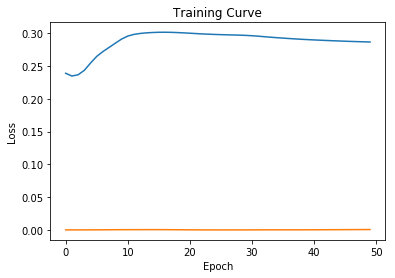

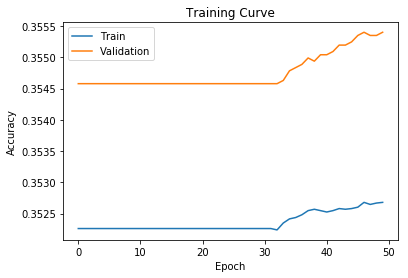

0.35267857142857145

In [0]:
torch.cuda.set_device(0)
model_gru5 = GRUModel(input_size = 6, hidden_size = 6, batch_size = 1, num_layers = 1).cuda()

train_rnn_network(model_gru5, train_data, val_data, num_epochs=50, learning_rate=10e-5)
get_accuracy(model_gru5, train_data)rand

Epoch 1; Loss 0.285247; Val_Loss 0.199214; Train Acc 0.358025; Val Acc 0.355195
Epoch 2; Loss 0.296687; Val_Loss 0.194470; Train Acc 0.358025; Val Acc 0.355195
Epoch 3; Loss 0.316654; Val_Loss 0.181232; Train Acc 0.358036; Val Acc 0.355195
Epoch 4; Loss 0.320868; Val_Loss 0.182018; Train Acc 0.358135; Val Acc 0.355144
Epoch 5; Loss 0.311599; Val_Loss 0.179129; Train Acc 0.358399; Val Acc 0.355247
Epoch 6; Loss 0.318032; Val_Loss 0.182705; Train Acc 0.358653; Val Acc 0.355710
Epoch 7; Loss 0.297322; Val_Loss 0.172011; Train Acc 0.358929; Val Acc 0.355864
Epoch 8; Loss 0.324341; Val_Loss 0.178532; Train Acc 0.359854; Val Acc 0.356533
Epoch 9; Loss 0.312275; Val_Loss 0.204124; Train Acc 0.359325; Val Acc 0.356687
Epoch 10; Loss 0.309362; Val_Loss 0.175850; Train Acc 0.359237; Val Acc 0.356224
Epoch 11; Loss 0.312647; Val_Loss 0.173366; Train Acc 0.359006; Val Acc 0.355504
Epoch 12; Loss 0.284138; Val_Loss 0.197539; Train Acc 0.358896; Val Acc 0.355813
Epoch 13; Loss 0.308421; Val_Loss 0.1

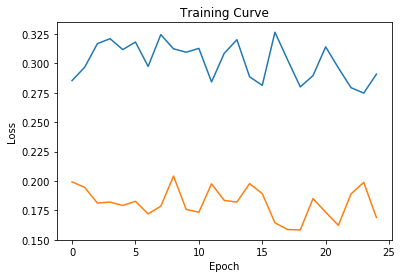

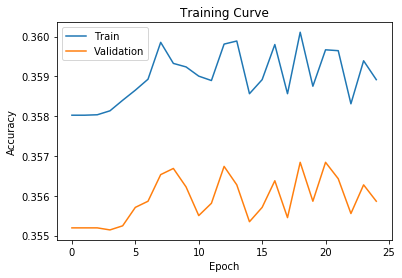

0.3589175485008818

In [0]:
torch.cuda.set_device(0)
model_gru = GRUModel(input_size = 14, hidden_size = 14, batch_size = 1, num_layers = 1).cuda()

train_rnn_network(model_gru, train_data, val_data, num_epochs=25, learning_rate=10e-4)
get_accuracy(model_gru, train_data)

Epoch 1; Loss 0.280022; Val_Loss 0.207319; Train Acc 0.358025; Val Acc 0.355195
Epoch 2; Loss 0.280056; Val_Loss 0.199358; Train Acc 0.358025; Val Acc 0.355195
Epoch 3; Loss 0.282116; Val_Loss 0.187594; Train Acc 0.358025; Val Acc 0.355195
Epoch 4; Loss 0.284124; Val_Loss 0.188716; Train Acc 0.358025; Val Acc 0.355195
Epoch 5; Loss 0.285137; Val_Loss 0.191136; Train Acc 0.358025; Val Acc 0.355195
Epoch 6; Loss 0.285235; Val_Loss 0.192607; Train Acc 0.358025; Val Acc 0.355195
Epoch 7; Loss 0.284968; Val_Loss 0.194384; Train Acc 0.358025; Val Acc 0.355195
Epoch 8; Loss 0.284341; Val_Loss 0.196231; Train Acc 0.358025; Val Acc 0.355195
Epoch 9; Loss 0.283213; Val_Loss 0.197544; Train Acc 0.358025; Val Acc 0.355195
Epoch 10; Loss 0.281453; Val_Loss 0.198305; Train Acc 0.358025; Val Acc 0.355195
Epoch 11; Loss 0.278620; Val_Loss 0.198908; Train Acc 0.358025; Val Acc 0.355195
Epoch 12; Loss 0.275112; Val_Loss 0.199872; Train Acc 0.358025; Val Acc 0.355195
Epoch 13; Loss 0.273102; Val_Loss 0.2

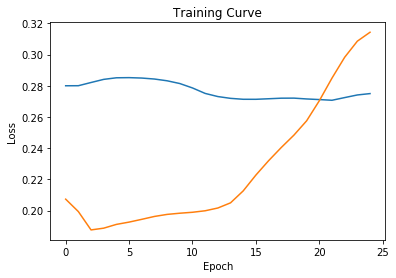

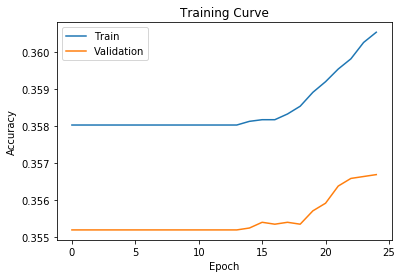

0.36052689594356263

In [0]:
torch.cuda.set_device(0)
model_gru = GRUModel(input_size = 14, hidden_size = 14, batch_size = 1, num_layers = 1).cuda()

train_rnn_network(model_gru, train_data, val_data, num_epochs=25, learning_rate=20e-5)
get_accuracy(model_gru, train_data)

In [0]:
#@title LSTM Model
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

#lstm_layer = nn.LSTM(input_size=50,   # dimension of the input repr
#                     hidden_size=50,   # dimension of the hidden units
#                     batch_first=True) # input format is [batch_size, seq_len, repr_dim]

def get_accuracy(model, data_loader):
    correct, total = 0.0, 0.0
    for info, labels in data_loader:
        pred = model(info.squeeze(0).cuda())
        #print(pred.item())
        #print(labels.item())
        #print("\n")
        if(pred.item()<0.33)and(labels.item()<0.33):
          correct += 1
        elif(0.33<pred.item()<0.67)and(0.33<labels.item()<0.67):
          correct += 1
        elif(pred.item()>0.67)and(labels.item()>0.67):
          correct += 1
        total += 1
    return correct / total

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, 
                 output_dim=1,num_layers = 1 ):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_dim)
        self.batch_size = batch_size
        self.sigmoid = nn.Sigmoid()
    
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
    
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.fc(lstm_out[-1].view(self.batch_size, -1))
        rt = self.sigmoid(y_pred.view(-1))
        return rt
      

def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    val_losses, losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for info, labels in train:
            optimizer.zero_grad()
            #print(info.squeeze(0))
            #print(labels)
            #model.hidden = model.init_hidden()
            pred = model(info.squeeze(0).cuda())
            #print(pred)
            #print(labels.unsqueeze(0))
            loss = criterion(pred, labels.unsqueeze(0).float().cuda())
            loss.backward()
            optimizer.step()
            #print(get_accuracy(model,train))
            
        losses.append(float(loss))
        
        for info, labels in valid:
            val_pred = model(info.squeeze(0).cuda())
            val_loss = criterion(val_pred, labels.unsqueeze(0).float().cuda())
        val_losses.append(float(val_loss))    
        
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Val_Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, val_loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(val_losses, label="Valid")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.287030; Val_Loss 0.205440; Train Acc 0.358025; Val Acc 0.355195
Epoch 2; Loss 0.278111; Val_Loss 0.202046; Train Acc 0.358025; Val Acc 0.355195
Epoch 3; Loss 0.272486; Val_Loss 0.198770; Train Acc 0.358025; Val Acc 0.355195
Epoch 4; Loss 0.270571; Val_Loss 0.195429; Train Acc 0.358025; Val Acc 0.355195
Epoch 5; Loss 0.270605; Val_Loss 0.191081; Train Acc 0.358025; Val Acc 0.355195
Epoch 6; Loss 0.272409; Val_Loss 0.186106; Train Acc 0.358025; Val Acc 0.355195
Epoch 7; Loss 0.282795; Val_Loss 0.181362; Train Acc 0.358025; Val Acc 0.355195
Epoch 8; Loss 0.281718; Val_Loss 0.178728; Train Acc 0.358025; Val Acc 0.355195
Epoch 9; Loss 0.280932; Val_Loss 0.178458; Train Acc 0.358025; Val Acc 0.355195
Epoch 10; Loss 0.280863; Val_Loss 0.176083; Train Acc 0.358025; Val Acc 0.355195
Epoch 11; Loss 0.280411; Val_Loss 0.170310; Train Acc 0.357925; Val Acc 0.355093
Epoch 12; Loss 0.278400; Val_Loss 0.168874; Train Acc 0.357881; Val Acc 0.355195
Epoch 13; Loss 0.274750; Val_Loss 0.1

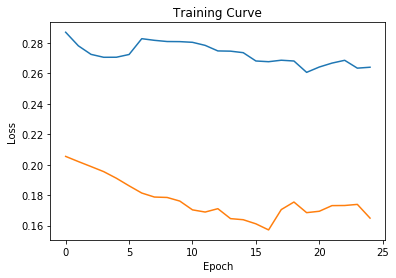

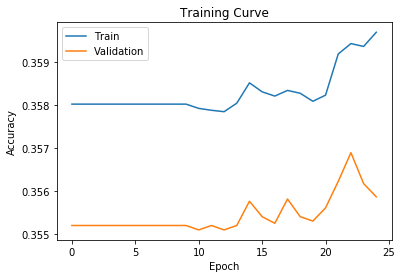

0.35970017636684304

In [0]:
torch.cuda.set_device(0)
model_lstm = LSTMModel(input_size = 14, hidden_size = 14, batch_size = 1, num_layers = 1).cuda()

train_rnn_network(model_lstm, train_data, val_data, num_epochs=25, learning_rate=20e-5)
get_accuracy(model_lstm, train_data)

In [0]:
torch.cuda.set_device(0)
model_gru2 = GRUModel(input_size = 14, hidden_size = 5, batch_size = 1, num_layers = 1).cuda()

train_rnn_network(model_gru2, train_data, val_data, num_epochs=200, learning_rate=1e-5)
get_accuracy(model_gru2, train_data)